# Geen tijd variabelen

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-07-30 12:15:55.079899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Laden

In [2]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [3]:
columns_to_retain = ['TRYHHCHILD', 'TEAGE', 'TESEX','PEEDUCA', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA',
'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRERNWA', 'TRCHILDNUM', 'TRSPFTPT', 'TEHRUSLT']

asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1[columns_to_retain]
print(df.shape)
df.head()

(21361, 18)


,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
3,8,31,2,40,1,2,2,1,2,2,2,-1,3,-1,469.44,3,-1,32
4,-1,59,2,39,1,2,1,1,1,2,-1,-1,1,2,302.50,0,-1,12
10,1,35,1,43,1,2,2,1,2,1,2,-1,1,1,1538.46,2,1,55
11,5,54,2,44,1,2,1,1,2,1,-1,-1,2,2,1211.53,2,-1,38
12,-1,40,2,43,1,2,2,1,2,1,2,-1,3,-1,961.53,0,-1,40


In [4]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022[columns_to_retain]
print(df2022.shape)
df2022.head()

(4226, 18)


,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
1,-1,30,2,39,1,2,1,1,2,1,2,-1,1,1,640.00,0,1,40
7,6,58,2,39,1,2,1,1,2,1,-1,-1,3,-1,1750.00,1,-1,55
8,-1,62,2,39,1,2,1,1,2,1,-1,-1,1,1,769.23,0,1,40
10,-1,45,2,39,1,2,2,1,2,1,2,-1,1,1,520.00,0,2,40
15,4,42,1,39,1,2,1,1,2,1,2,-1,2,2,1615.38,1,-1,50


In [5]:
# One-Hot Encoding
one_hot_vars = ['TESEX', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA', 'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRSPFTPT']
df_encoded = pd.get_dummies(df, columns=one_hot_vars)

# Label Encoding
label_encoder = LabelEncoder()
df_encoded['PEEDUCA'] = label_encoder.fit_transform(df['PEEDUCA'])
df_encoded.head()

,TRYHHCHILD,TEAGE,PEEDUCA,TRERNWA,TRCHILDNUM,TEHRUSLT,TESEX_1,TESEX_2,PTDTRACE_1,PTDTRACE_2,...,TRSPPRES_1,TRSPPRES_2,TRSPPRES_3,TESPEMPNOT_-1,TESPEMPNOT_1,TESPEMPNOT_2,TRSPFTPT_-1,TRSPFTPT_1,TRSPFTPT_2,TRSPFTPT_3
3,8,31,9,469.44,3,32,False,True,True,False,...,False,False,True,True,False,False,True,False,False,False
4,-1,59,8,302.50,0,12,False,True,True,False,...,True,False,False,False,False,True,True,False,False,False
10,1,35,12,1538.46,2,55,True,False,True,False,...,True,False,False,False,True,False,False,True,False,False
11,5,54,13,1211.53,2,38,False,True,True,False,...,False,True,False,False,False,True,True,False,False,False
12,-1,40,12,961.53,0,40,False,True,True,False,...,False,False,True,True,False,False,True,False,False,False


In [6]:
encoded2022 = pd.get_dummies(df2022, columns=one_hot_vars)
encoded2022['PEEDUCA'] = label_encoder.fit_transform(df2022['PEEDUCA'])

encoded2022.head()

,TRYHHCHILD,TEAGE,PEEDUCA,TRERNWA,TRCHILDNUM,TEHRUSLT,TESEX_1,TESEX_2,PTDTRACE_1,PTDTRACE_2,...,TRSPPRES_1,TRSPPRES_2,TRSPPRES_3,TESPEMPNOT_-1,TESPEMPNOT_1,TESPEMPNOT_2,TRSPFTPT_-1,TRSPFTPT_1,TRSPFTPT_2,TRSPFTPT_3
1,-1,30,8,640.00,0,40,False,True,True,False,...,True,False,False,False,True,False,False,True,False,False
7,6,58,8,1750.00,1,55,False,True,True,False,...,False,False,True,True,False,False,True,False,False,False
8,-1,62,8,769.23,0,40,False,True,True,False,...,True,False,False,False,True,False,False,True,False,False
10,-1,45,8,520.00,0,40,False,True,True,False,...,True,False,False,False,True,False,False,False,True,False
15,4,42,8,1615.38,1,50,True,False,True,False,...,False,True,False,False,False,True,True,False,False,False


In [7]:
kolommen_df1 = set(df.columns)
kolommen_df2 = set(df2022.columns)

ontbrekende_in_df1 = kolommen_df2 - kolommen_df1
ontbrekende_in_df2 = kolommen_df1 - kolommen_df2

print("Ontbrekende kolommen in df1:", ontbrekende_in_df1)
print("Ontbrekende kolommen in df2:", ontbrekende_in_df2)

for kolom in ontbrekende_in_df1:
    df[kolom] = 0

for kolom in ontbrekende_in_df2:
    df2022[kolom] = 0

print(df.shape)
print(df2022.shape)

# Juiste volgorde
alle_kolommen = sorted(list(kolommen_df1 | kolommen_df2))
df = df[alle_kolommen]
df2022 = df2022[alle_kolommen]

Ontbrekende kolommen in df1: set()
Ontbrekende kolommen in df2: set()
(21361, 18)
(4226, 18)


In [8]:
kolommen_df1 = set(df_encoded.columns)
kolommen_df2 = set(encoded2022.columns)

ontbrekende_in_df1 = kolommen_df2 - kolommen_df1
ontbrekende_in_df2 = kolommen_df1 - kolommen_df2

print("Ontbrekende kolommen in df1:", ontbrekende_in_df1)
print("Ontbrekende kolommen in df2:", ontbrekende_in_df2)

for kolom in ontbrekende_in_df1:
    df_encoded[kolom] = 0

for kolom in ontbrekende_in_df2:
    encoded2022[kolom] = 0

print(df_encoded.shape)
print(encoded2022.shape)

# Juiste volgorde
alle_kolommen = sorted(list(kolommen_df1 | kolommen_df2))
df_encoded = df_encoded[alle_kolommen]
encoded2022 = encoded2022[alle_kolommen]

Ontbrekende kolommen in df1: set()
Ontbrekende kolommen in df2: {'PTDTRACE_21', 'PTDTRACE_19', 'PTDTRACE_12', 'PTDTRACE_18', 'PTDTRACE_15'}
(21361, 53)
(4226, 53)


In [9]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

train_set, test_set = train_test_split(df_encoded, test_size=0.2, random_state=10)

X_train_encoded = train_set.drop("TRERNWA", axis=1)
y_train_encoded = train_set["TRERNWA"]
X_test_encoded = test_set.drop("TRERNWA", axis=1)
y_test_encoded = test_set["TRERNWA"]

In [10]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

X_encoded2022 = encoded2022.drop("TRERNWA", axis=1)
y_encoded2022 = encoded2022["TRERNWA"]

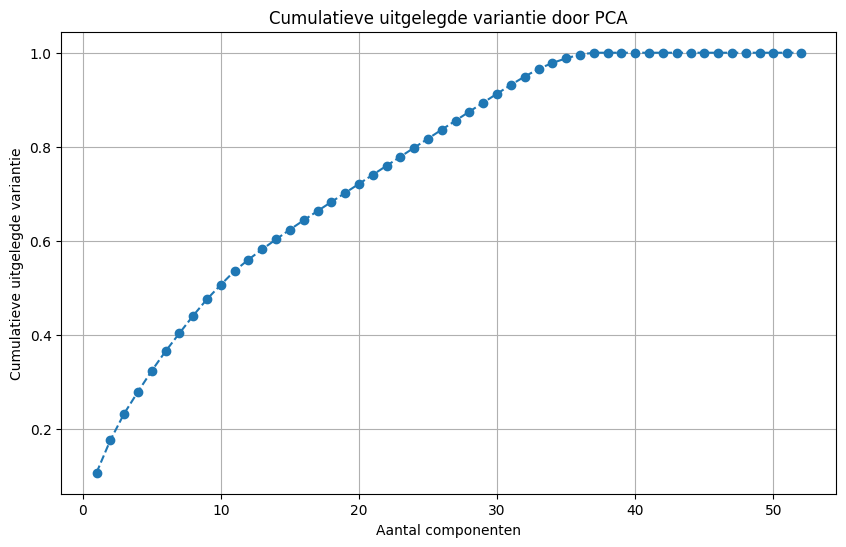

Aantal componenten dat 95% van de variantie verklaart: 33
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.357349  0.452177 -0.111774 -0.935302 -0.856081 -0.138449 -0.483042   
1  2.192168 -1.496639  0.788626 -0.263999 -0.209972  0.002606 -0.591117   
2 -1.908262 -0.667159  2.551808  0.044582  0.158346 -0.332928 -1.292796   
3 -2.137823 -0.128985  0.549117  0.182797 -0.204532  2.871714  1.415261   
4 -0.208084 -0.927562 -1.886581  1.359135  0.633105 -0.513689  1.072626   

        PC8       PC9      PC10  ...      PC25      PC26      PC27      PC28  \
0 -0.256579 -1.284897 -0.294700  ...  0.045510  0.020794  0.009302  0.012347   
1 -0.123943 -1.195505 -0.576511  ... -0.046506 -0.107492  0.018272  0.146230   
2 -0.270369 -1.548407  0.051626  ...  0.057521 -0.026814  0.019789  0.147468   
3 -0.215571 -1.331342  0.646928  ... -0.019578  0.013098 -0.143131 -0.310835   
4 -0.325887  0.500611 -0.422553  ... -0.081885  0.110553 -0.219192  0.554248   

       PC2

In [13]:
target_column = 'TRERNWA'
df_target = df_encoded[target_column]
df_features = df_encoded.drop(columns=[target_column])

df2022_target = encoded2022[target_column]
df2022_features = encoded2022.drop(columns=[target_column])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

df2022_scaled = scaler.transform(df2022_features)

pca = PCA()
principal_components = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--')
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve uitgelegde variantie')
plt.title('Cumulatieve uitgelegde variantie door PCA')
plt.grid()
plt.show()

n_components = next(i for i, total_var in enumerate(explained_variance_cumsum) if total_var > 0.95) + 1
print(f'Aantal componenten dat 95% van de variantie verklaart: {n_components}')

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

df2022_pca = pca.transform(df2022_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca_df = pd.DataFrame(data=df_pca, columns=pca_columns)
df2022_pca_df = pd.DataFrame(data=df2022_pca, columns=pca_columns)

df_with_pca = pd.concat([df_pca_df, df_target.reset_index(drop=True)], axis=1)
df2022_with_pca = pd.concat([df2022_pca_df, df2022_target.reset_index(drop=True)], axis=1)

print(df2022_with_pca.head())

In [14]:
train_set, test_set = train_test_split(df_with_pca, test_size=0.2, random_state=10)

X_train_pca = train_set.drop("TRERNWA", axis=1)
y_train_pca = train_set["TRERNWA"]
X_test_pca = test_set.drop("TRERNWA", axis=1)
y_test_pca = test_set["TRERNWA"]

X_pca2022 = df2022_with_pca.drop("TRERNWA", axis=1)
y_pca2022 = df2022_with_pca["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 439.51785631245514
R2 Score: 0.4164397460336797
______

2022 MAE: 488.7493355277893
2022 R2 Score: 0.35067526772675506



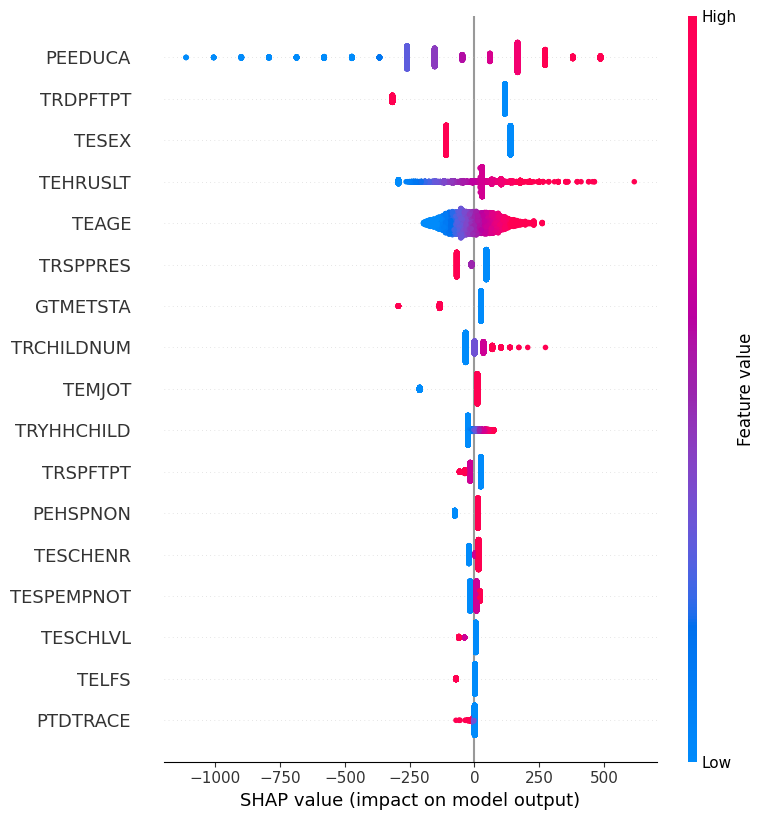

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### Encoded


Test MAE: 439.32337036500957
R2 Score: 0.4179756368030013
______

2022 MAE: 491.6716334199868
2022 R2 Score: 0.3497429422885133



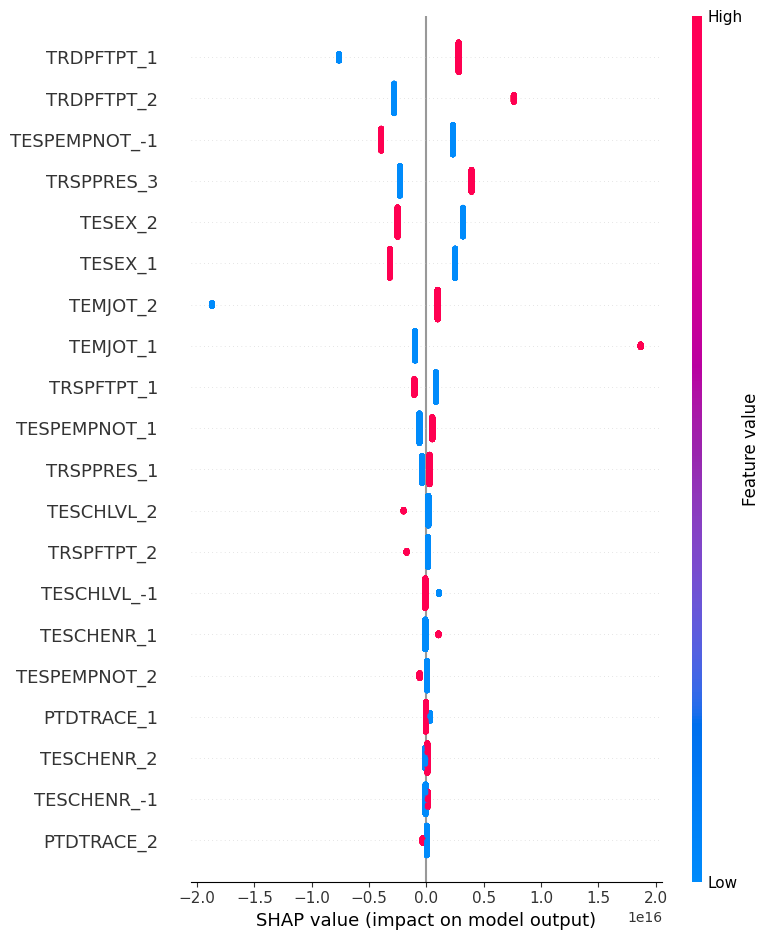

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train_encoded)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA


Test MAE: 459.6047519246373
R2 Score: 0.3621008523750727
______

2022 MAE: 510.3384563903046
2022 R2 Score: 0.29059455738299356



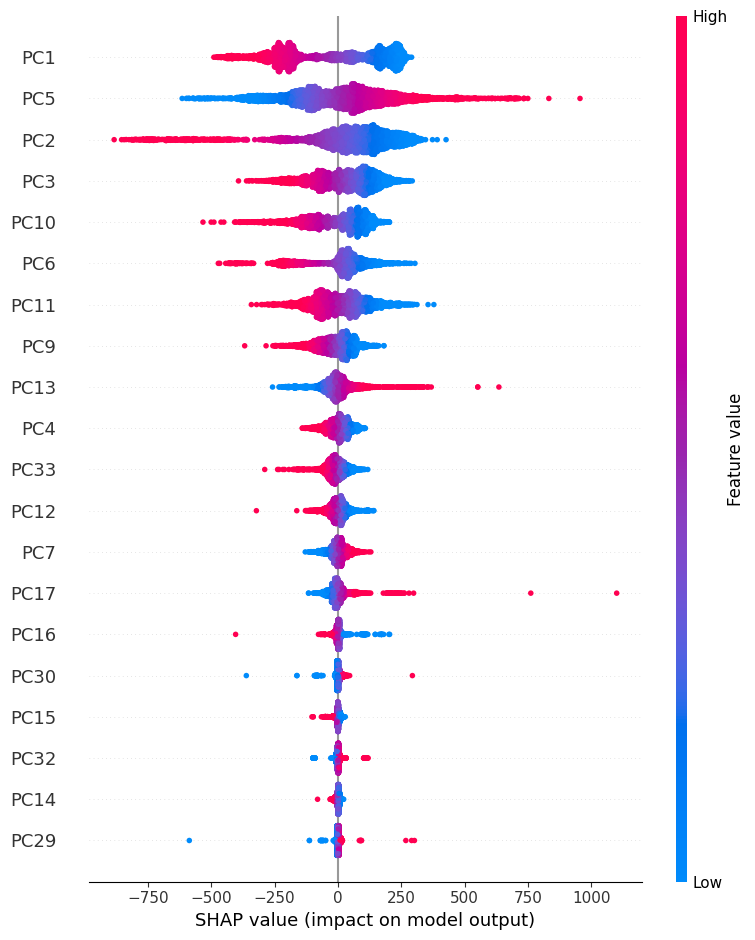

In [20]:
model = LinearRegression()
model.fit(X_train_pca, y_train_pca)

y_pred = model.predict(X_test_pca)
y_pred2022 = model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_pca)

shap_values_test = explainer.shap_values(X_test_pca)

shap.summary_plot(shap_values_test, X_test_pca, feature_names=X_train_pca.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 439.4831204038569
R2 Score: 0.41637098128505223
______

2022 MAE: 488.7536499014335
2022 R2 Score: 0.35030105594550964



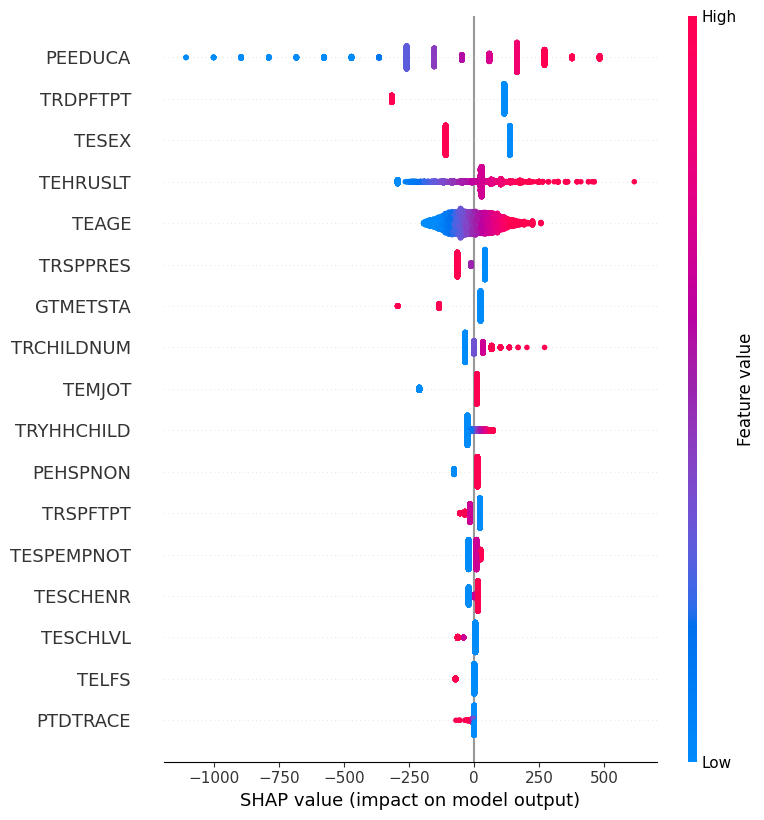

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### Encoded

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 434.4516776999296
R2 Score: 0.4276525692647095
______

2022 MAE: 486.0342470224028
2022 R2 Score: 0.35869231403687907



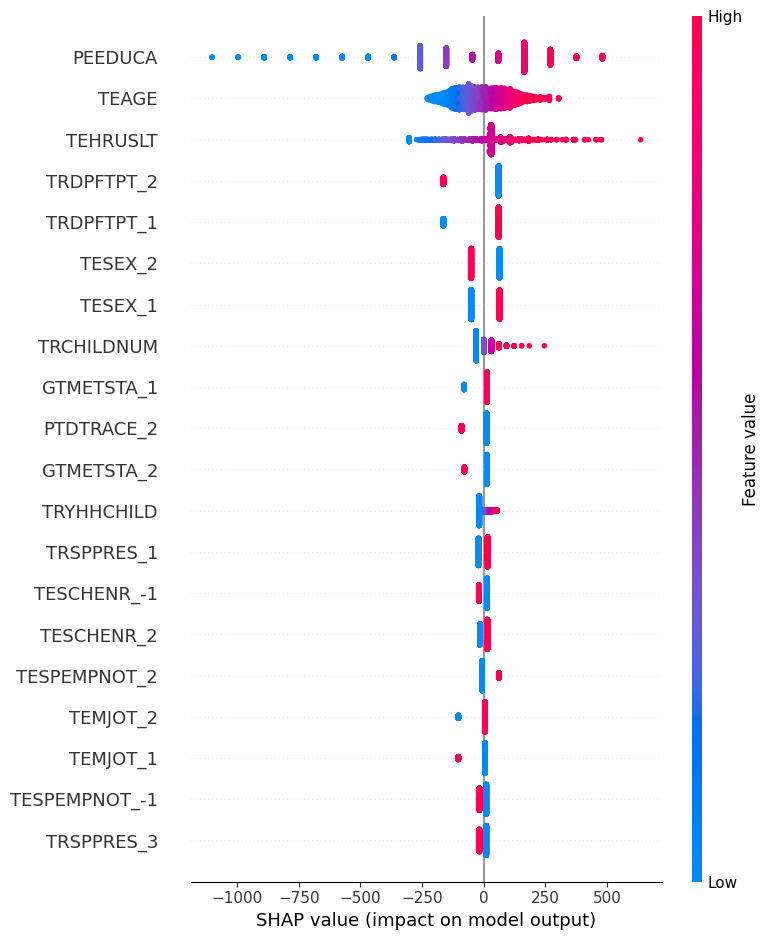

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

ridge_model = Ridge()

param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 459.5962593515618
R2 Score: 0.3620496381269046
______

2022 MAE: 510.35563576719676
2022 R2 Score: 0.2903923164097949



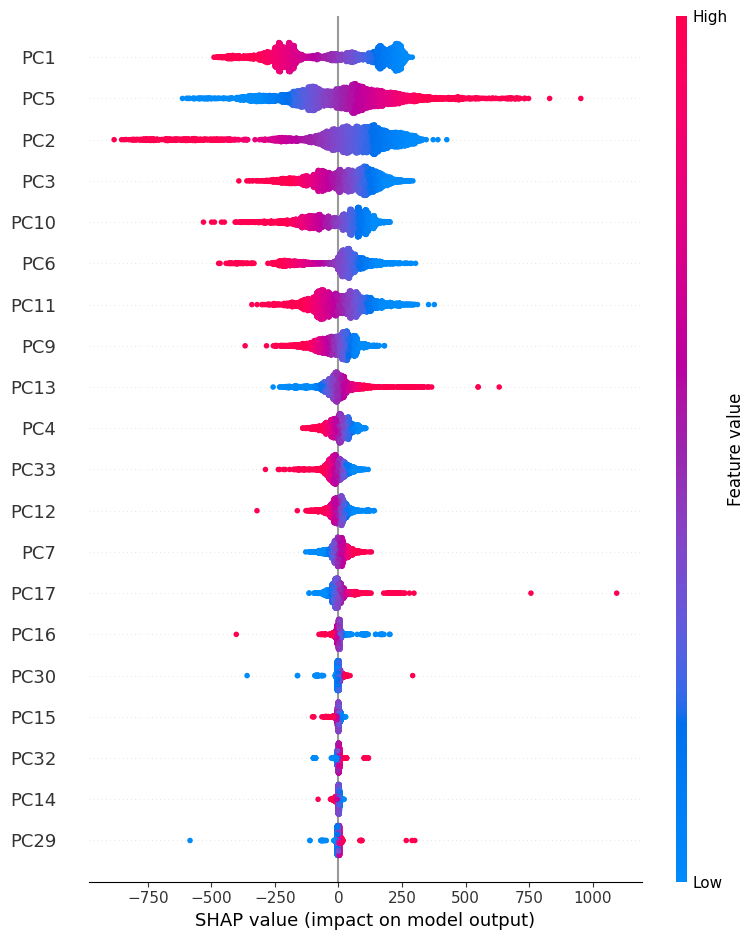

In [22]:
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = best_ridge_model.predict(X_test_pca)
y_pred2022 = best_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_pca)
shap_values_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])

plt.show()

#### Lasso Regressie

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 438.9374033533866
R2 Score: 0.41445100249579736
______

2022 MAE: 488.7420623472079
2022 R2 Score: 0.3467689496832955



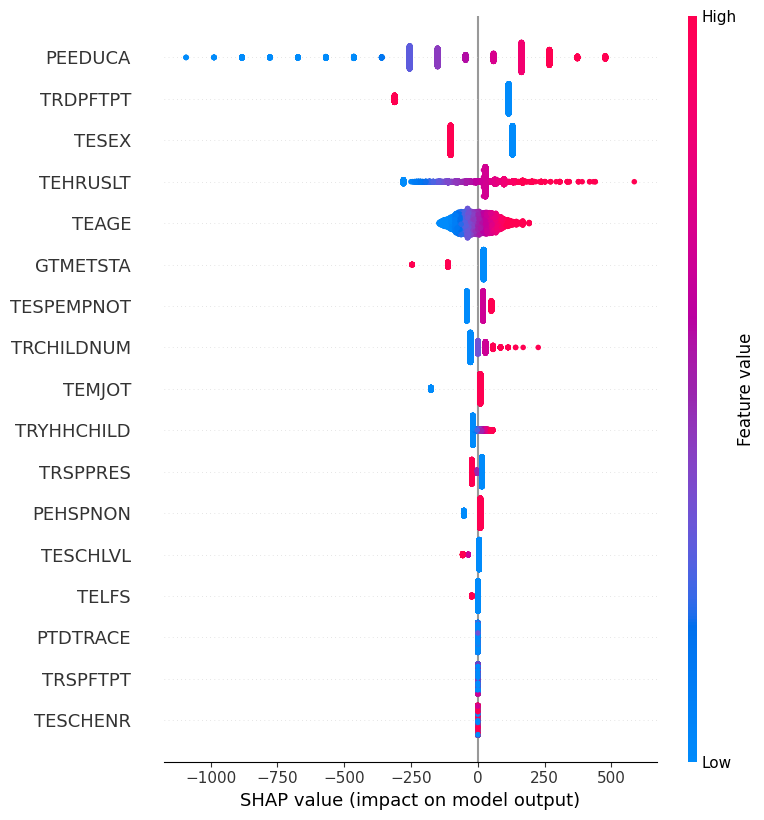

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### Encoded

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+06, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.553e+06, tolerance: 7.534e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Beste hyperparameters: {'alpha': 1.0}

Test MAE: 434.32314530377147
R2 Score: 0.4277817196211101
______

2022 MAE: 485.8671803169767
2022 R2 Score: 0.3591875363723621



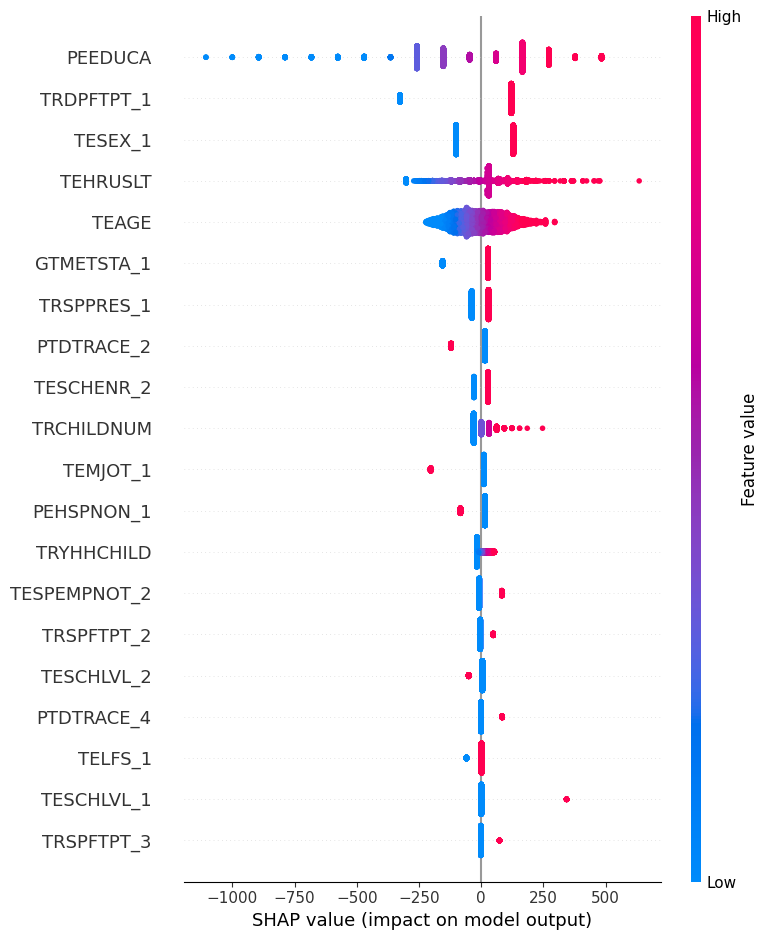

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e+09, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+09, tolerance: 7.534e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 461.01129123298335
R2 Score: 0.35802446350284844
______

2022 MAE: 512.0861612500412
2022 R2 Score: 0.28375948501998316



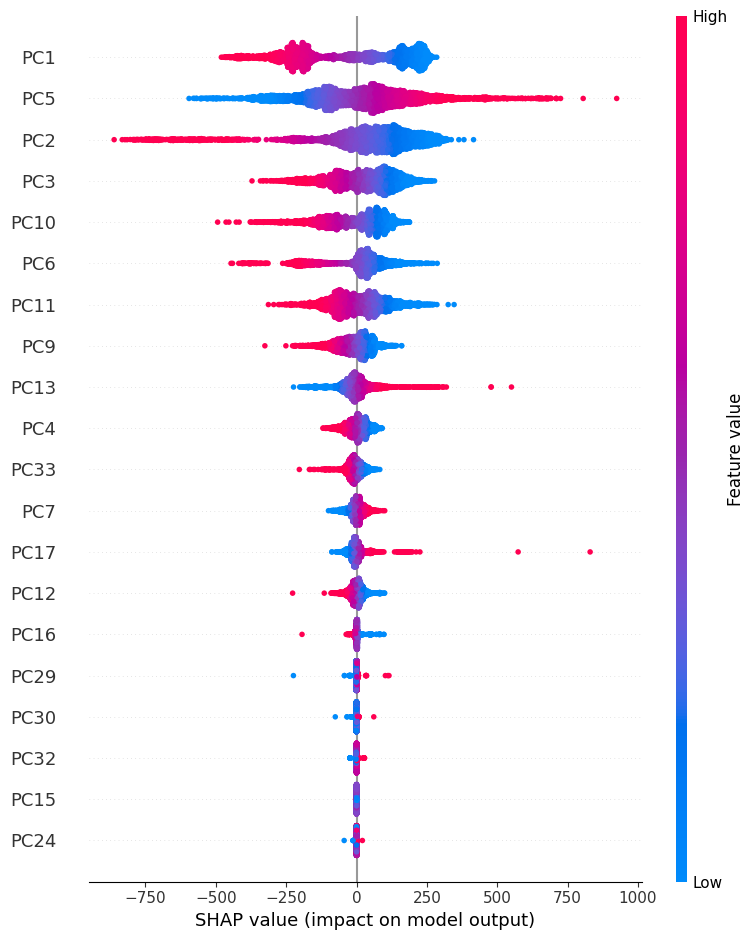

In [23]:
lasso_model = Lasso()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_pca, y_train_pca)

y_pred = best_lasso_model.predict(X_test_pca)
y_pred2022 = best_lasso_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_pca)
shap_values_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])

plt.show()

#### Bayesian Ridge Regression


Test MAE: 439.50489249455325
R2 Score: 0.4164179253841086
______

2022 MAE: 488.748885231393
2022 R2 Score: 0.3505435777805562



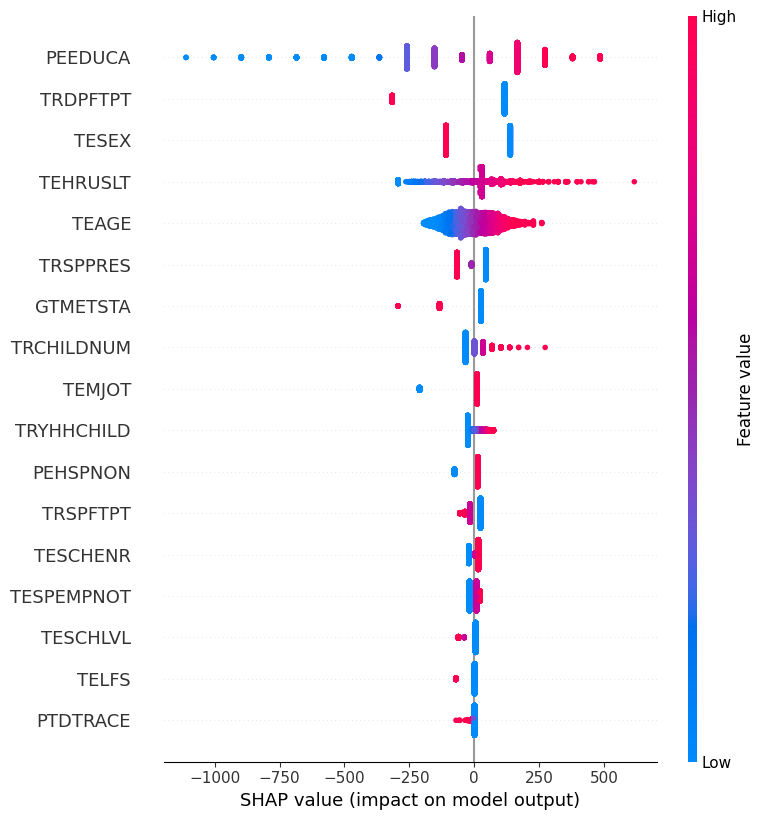

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### Encoded


Test MAE: 434.45507339578046
R2 Score: 0.42765995395958123
______

2022 MAE: 486.03394702980154
2022 R2 Score: 0.35872806833591653



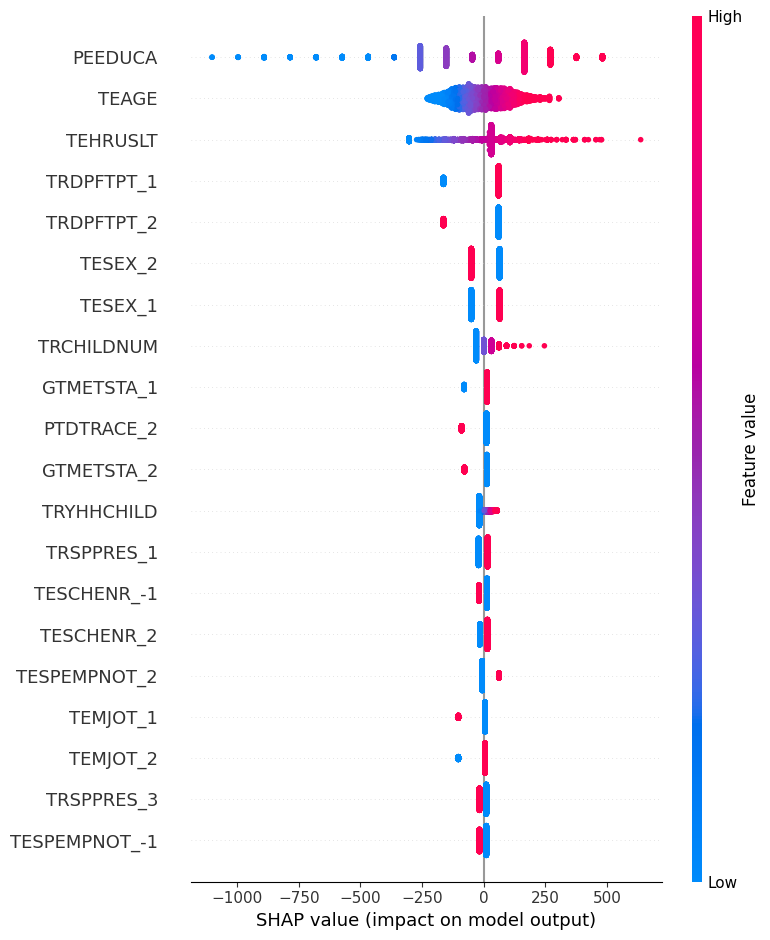

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA


Test MAE: 459.5919052932936
R2 Score: 0.3620183371072352
______

2022 MAE: 510.3659654346511
2022 R2 Score: 0.2902749677447979



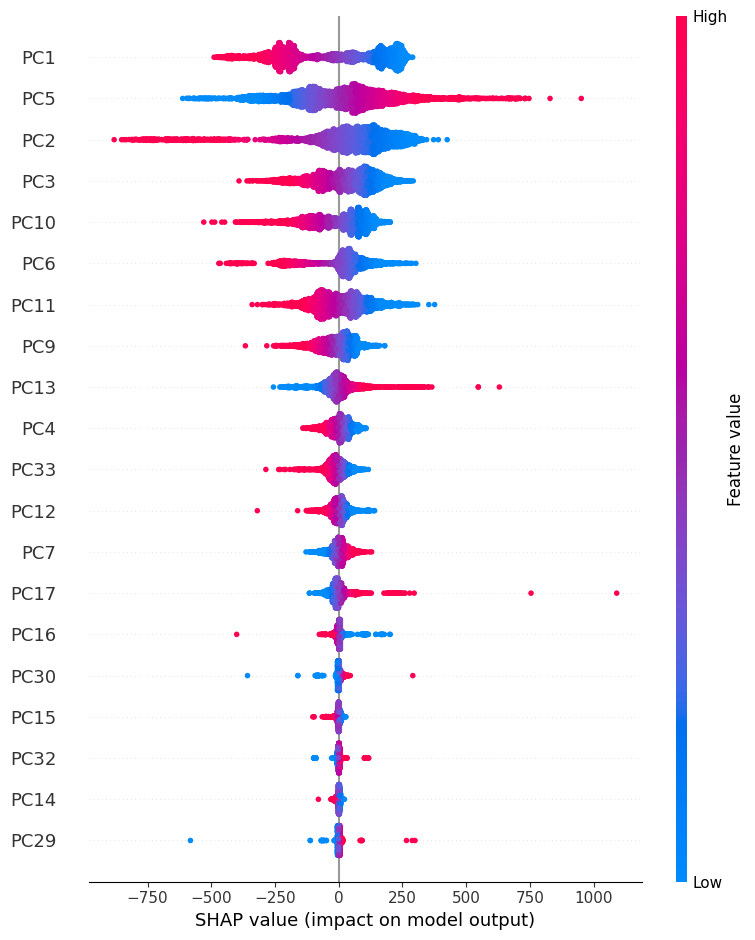

In [29]:
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = bayesian_ridge_model.predict(X_test_pca)
y_pred2022 = bayesian_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_pca)
shap_values_test = explainer.shap_values(X_test_pca)

shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])

plt.show()

### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Test MAE: 406.85052209798516
R2 Score: 0.4458433913609291
______

2022 MAE: 456.37310880169593
2022 R2 Score: 0.3877505110016751



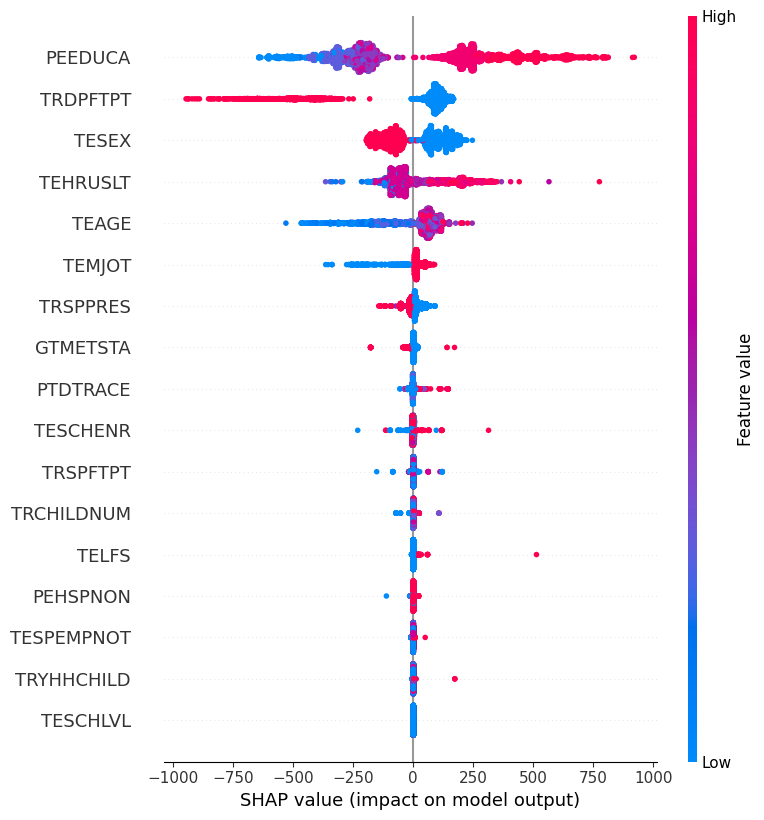

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### Encoded

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}

Test MAE: 406.2814033082419
R2 Score: 0.44705481356837895
______

2022 MAE: 455.81173112041125
2022 R2 Score: 0.3891704926921683



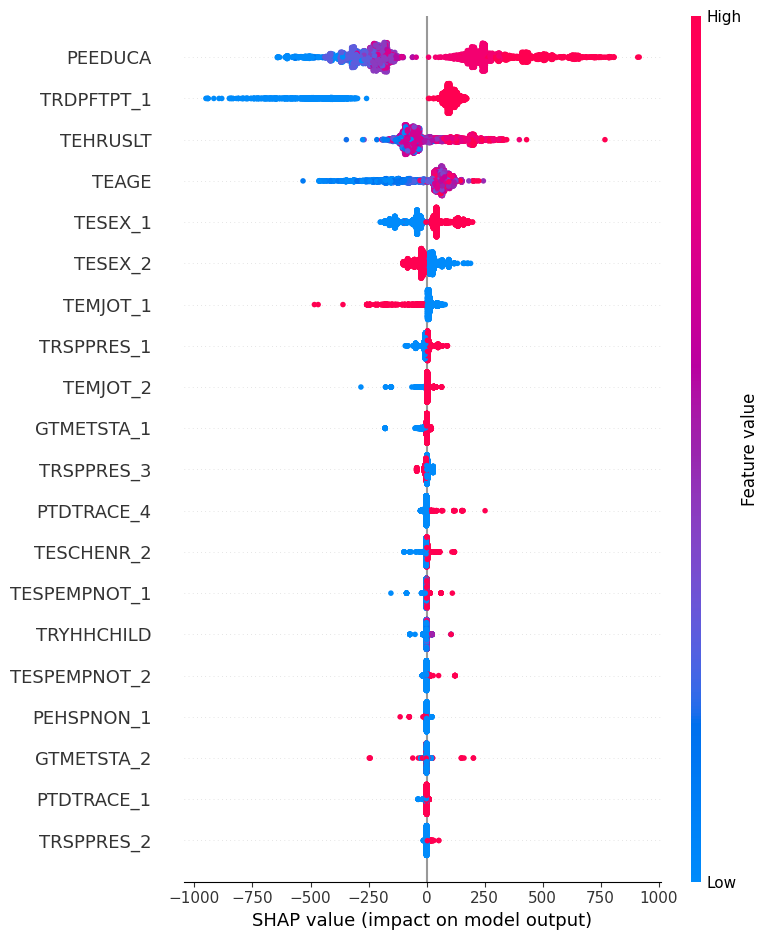

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}

Test MAE: 457.98363212130073
R2 Score: 0.3334375903040093
______

2022 MAE: 515.3316472481876
2022 R2 Score: 0.26468828282118984



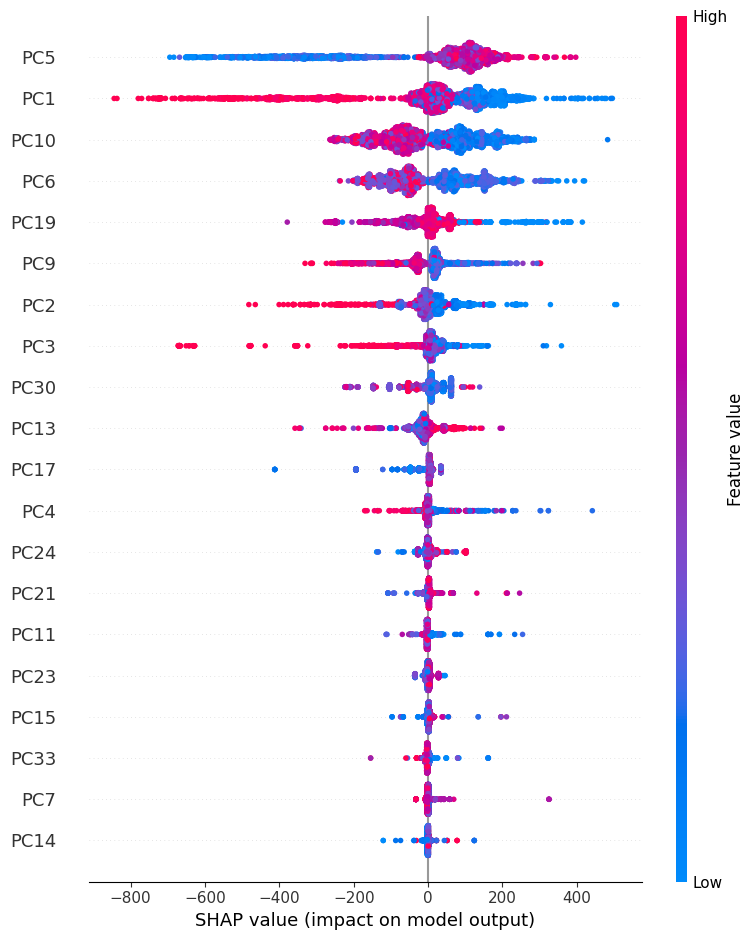

In [24]:
tree_model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_pca, y_train_pca)

y_pred = best_tree_model.predict(X_test_pca)
y_pred2022 = best_tree_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)
shap_values_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])

plt.show()

#### Random Forests

Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 390.7094722281787
R2 Score: 0.4894230075795527
______

2022 MAE: 440.00916412973186
2022 R2 Score: 0.4253311716477105



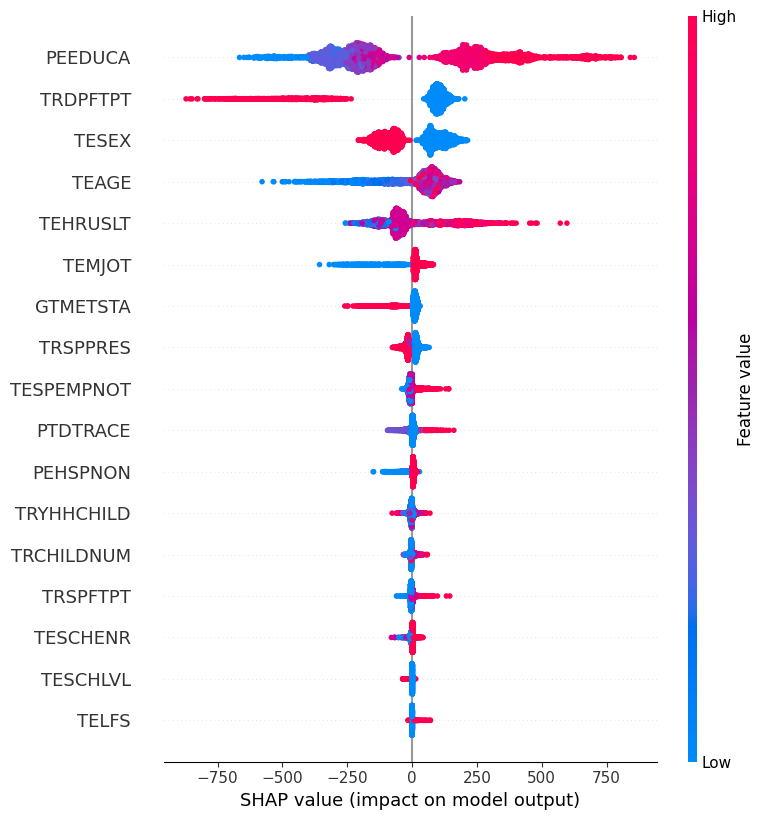

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

##### Encoded

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 390.41600018671727
R2 Score: 0.4904169263015239
______

2022 MAE: 439.50468199707285
2022 R2 Score: 0.4267393987373791



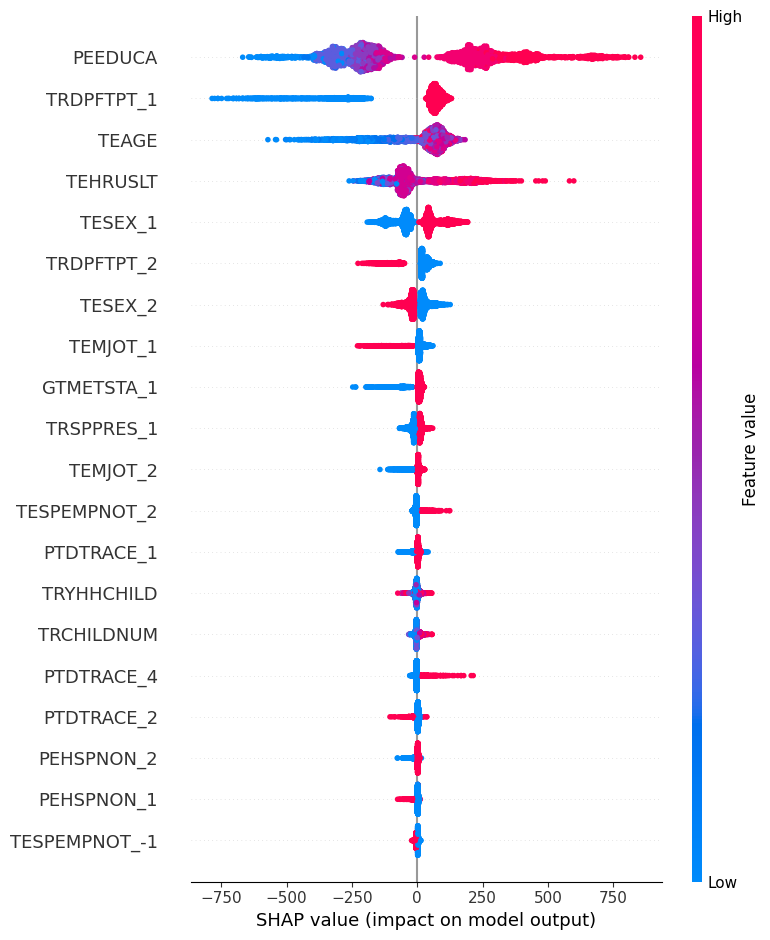

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 412.2382860190291
R2 Score: 0.45126219971391135
______

2022 MAE: 465.01610432014144
2022 R2 Score: 0.375003931280132



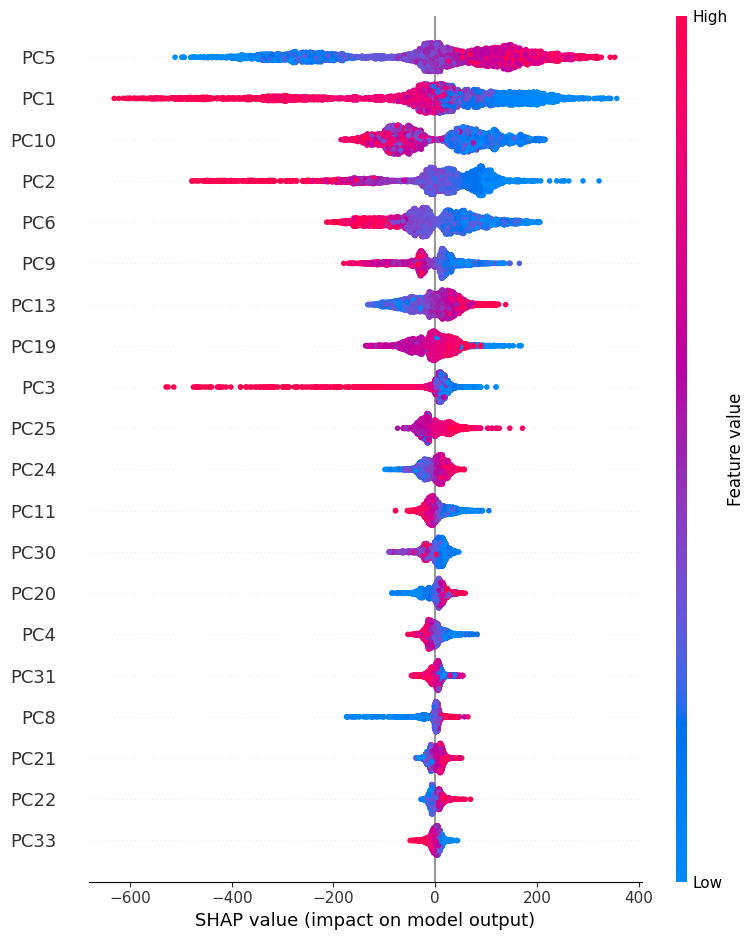

In [25]:
rf_model = RandomForestRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_pca, y_train_pca)

y_pred = best_rf_model.predict(X_test_pca)
y_pred2022 = best_rf_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
plt.show()

#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 385.6630316866305
R2 Score: 0.5023489805946977
______

2022 MAE: 440.20572287577346
2022 R2 Score: 0.42919588659725283



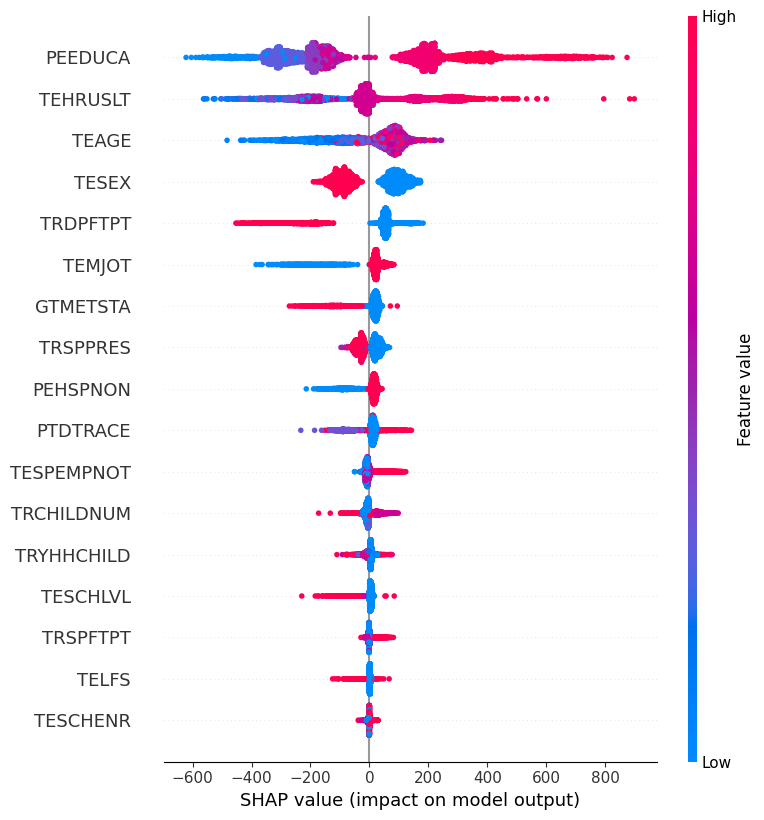

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

##### Encoded

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 385.7042622282506
R2 Score: 0.5021411327584482
______

2022 MAE: 439.74239345593895
2022 R2 Score: 0.43159226913141857



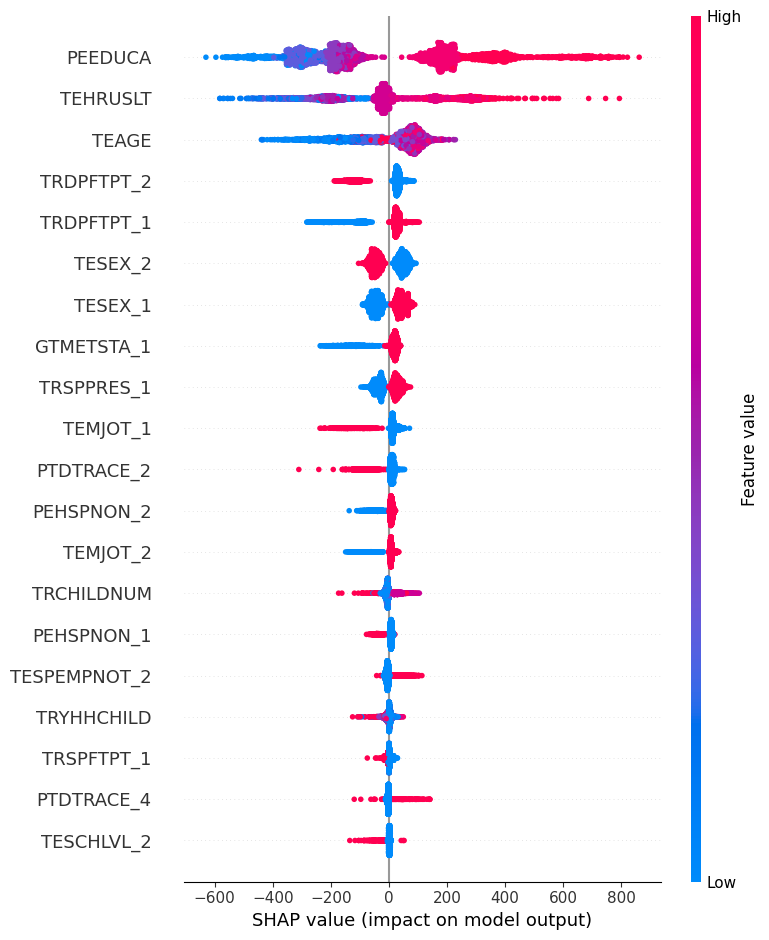

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Test MAE: 408.5970170212958
R2 Score: 0.4550192664498094
______

2022 MAE: 457.7938325785147
2022 R2 Score: 0.39354727557305447



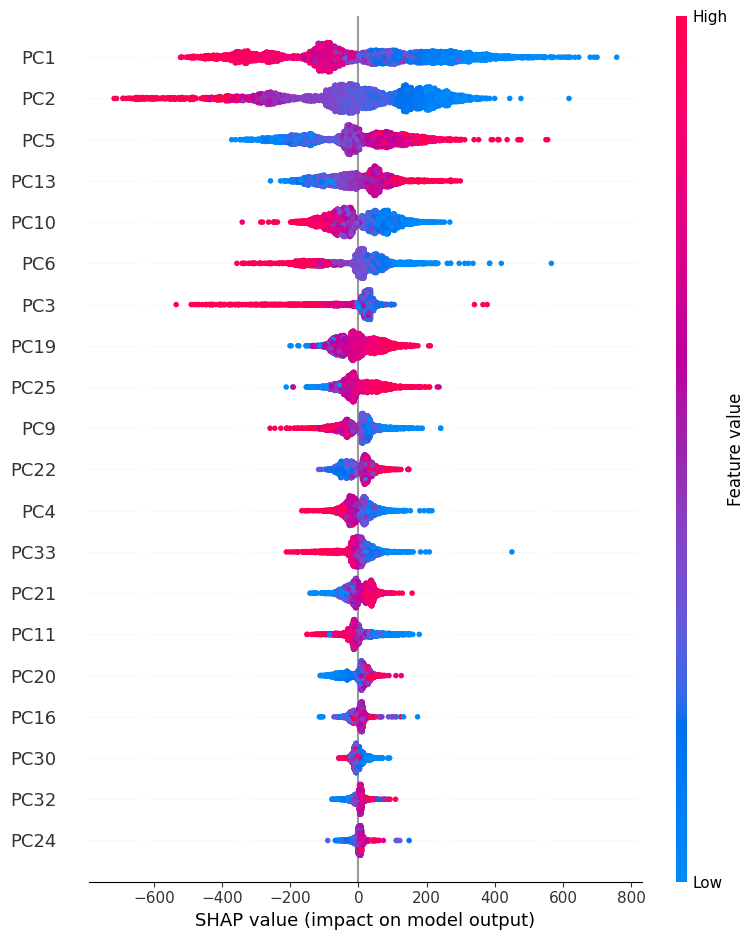

In [26]:
gbr_model = GradientBoostingRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_pca, y_train_pca)

y_pred = best_gbr_model.predict(X_test_pca)
y_pred2022 = best_gbr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values_test, X_test_pca, feature_names=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
plt.show()

#### Support Vector Machines (SVM)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


SVR(C=100, epsilon=1)


Test MAE: 381.74240873103696
R2 Score: 0.46996217657279227
______

2022 MAE: 467.57693757485544
2022 R2 Score: 0.33423320178098637



  0%|          | 0/100 [00:00<?, ?it/s]

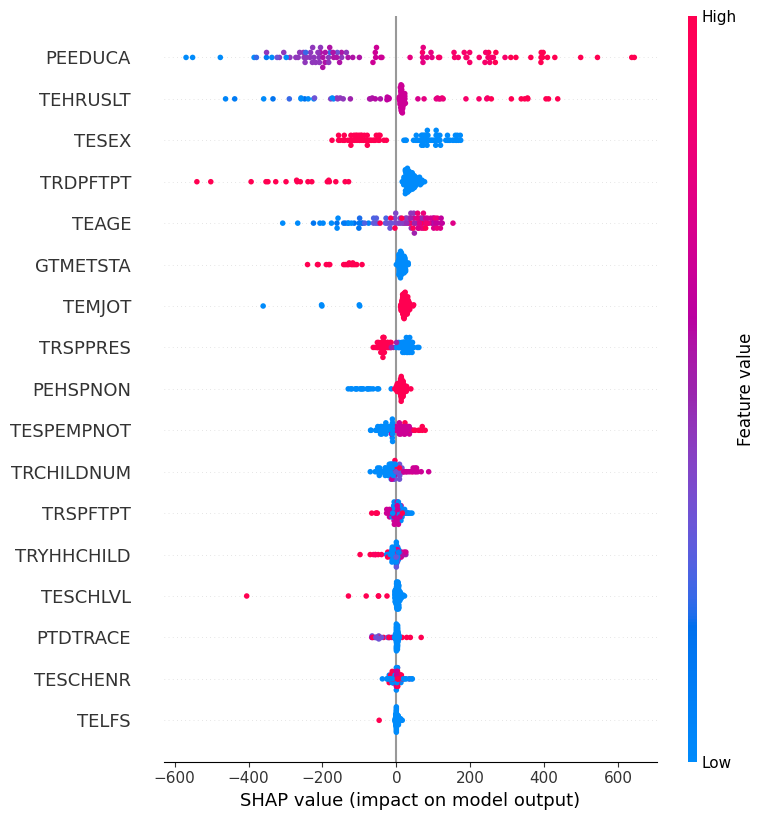

In [15]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  # Verminder aantal clusters
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

##### Encoded

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}

Test MAE: 387.83052894693776
R2 Score: 0.459563245355863
______

2022 MAE: 473.4892036871369
2022 R2 Score: 0.3195123758770918



##### PCA

In [15]:
svr_model = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_pca, y_train_pca)

y_pred = best_svr_model.predict(X_test_pca)
y_pred2022 = best_svr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}

Test MAE: 398.0009237714006
R2 Score: 0.43411824396999943
______

2022 MAE: 485.0872786688129
2022 R2 Score: 0.2893816962197078



#### K-Nearest Neighbors (KNN)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'}


KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11)


Test MAE: 417.2657579303449
R2 Score: 0.43140105563334386
______

2022 MAE: 460.96121240803683
2022 R2 Score: 0.37374212610034796



  0%|          | 0/17088 [00:00<?, ?it/s]

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/U

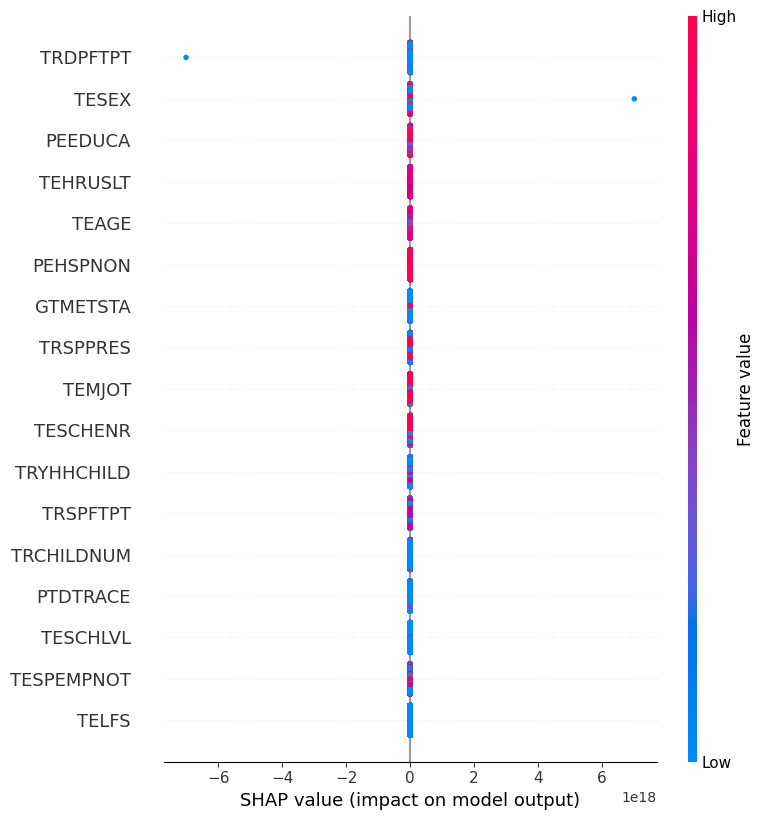

In [26]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

X_sample = shap.sample(X_train_scaled, 50)

explainer = shap.KernelExplainer(best_knn_model.predict, X_sample)
shap_values = explainer.shap_values(X_train_scaled, nsamples=50)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Beste hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'}

Test MAE: 426.5645960896113
R2 Score: 0.4108476126109176
______

2022 MAE: 471.22228262272506
2022 R2 Score: 0.3559431475354373



##### PCA

In [28]:
knn_model = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_pca, y_train_pca)

y_pred = best_knn_model.predict(X_test_pca)
y_pred2022 = best_knn_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'weights': 'uniform'}

Test MAE: 430.1825666446823
R2 Score: 0.40033672437147705
______

2022 MAE: 474.7221688250226
2022 R2 Score: 0.34768718550245425



### Deep Learning Modellen

Epoch 1/100


2024-07-30 12:16:20.147921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 1ms/step - loss: 1219967.5000 - mae: 848.4271 - val_loss: 417199.8750 - val_mae: 453.2177
Epoch 2/100
428/428 [==============================] - 0s 784us/step - loss: 342380.8750 - mae: 431.3920 - val_loss: 322332.4375 - val_mae: 423.0438
Epoch 3/100
428/428 [==============================] - 0s 784us/step - loss: 319790.2188 - mae: 420.1897 - val_loss: 315300.6875 - val_mae: 416.6350
Epoch 4/100
428/428 [==============================] - 0s 928us/step - loss: 313813.1875 - mae: 416.2105 - val_loss: 311589.8438 - val_mae: 412.9634
Epoch 5/100
428/428 [==============================] - 0s 774us/step - loss: 310546.4688 - mae: 413.4595 - val_loss: 310312.2188 - val_mae: 410.6259
Epoch 6/100
428/428 [==============================] - 0s 773us/step - loss: 308789.1250 - mae: 411.9620 - val_loss: 308515.0938 - val_mae: 412.0123
Epoch 7/100
428/428 [==============================] - 0s 781us/step - loss: 307219.7500 - mae: 411.1263 - val_loss: 30

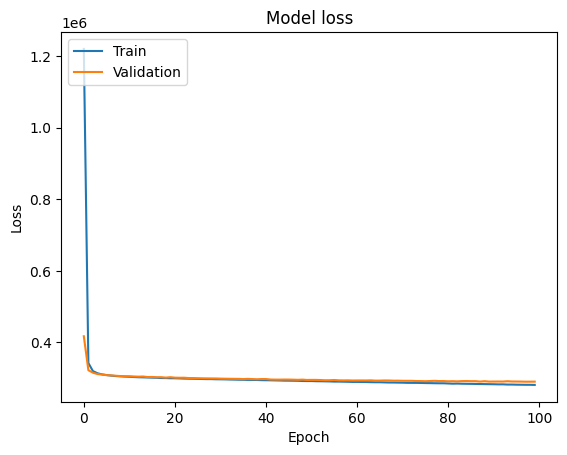

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [01:36, 39.51it/s]                       


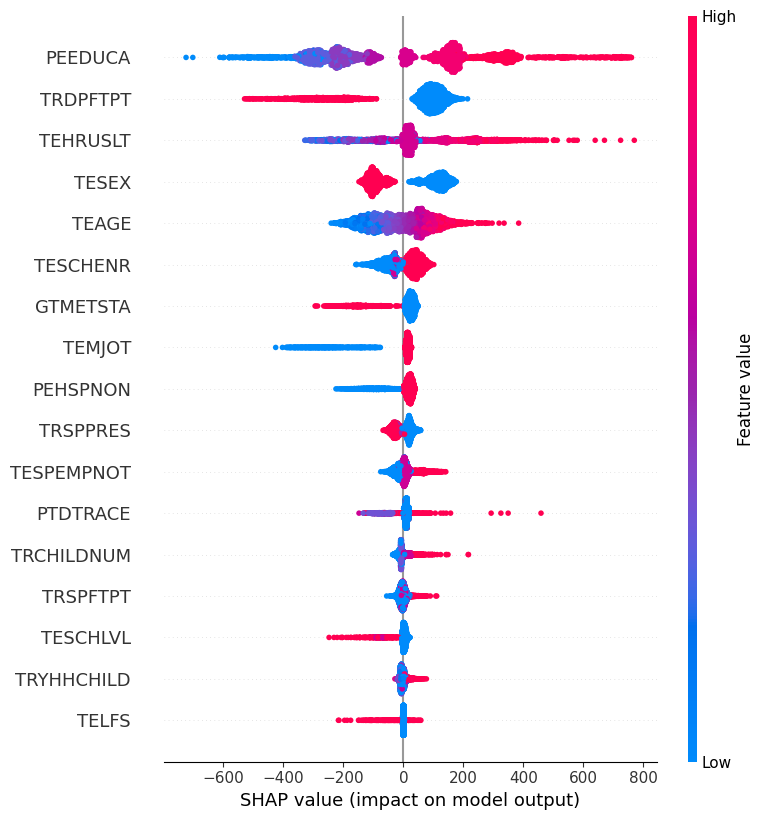

In [14]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Random Search

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10, 
    executions_per_trial=2, 
    directory='my_dir',
    project_name='income_prediction1'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 00m 40s]
val_mae: 388.6422119140625

Best val_mae So Far: 386.75244140625
Total elapsed time: 00h 07m 21s
Epoch 1/50
214/214 [==============================] - 1s 2ms/step - loss: 541222.0000 - mae: 530.2550 - val_loss: 309074.5312 - val_mae: 409.9695
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 307886.0000 - mae: 409.2098 - val_loss: 305720.9688 - val_mae: 414.8738
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 305476.8750 - mae: 407.2210 - val_loss: 302240.1250 - val_mae: 403.2240
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 301769.4375 - mae: 404.9634 - val_loss: 302947.0000 - val_mae: 410.5555
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 301100.0312 - mae: 403.5323 - val_loss: 299465.0312 - val_mae: 405.1525
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 298741.0625 - mae: 402.4984 - val_loss: 300759.1562 - val_mae: 397.

PermutationExplainer explainer: 4274it [07:10,  9.69it/s]                       


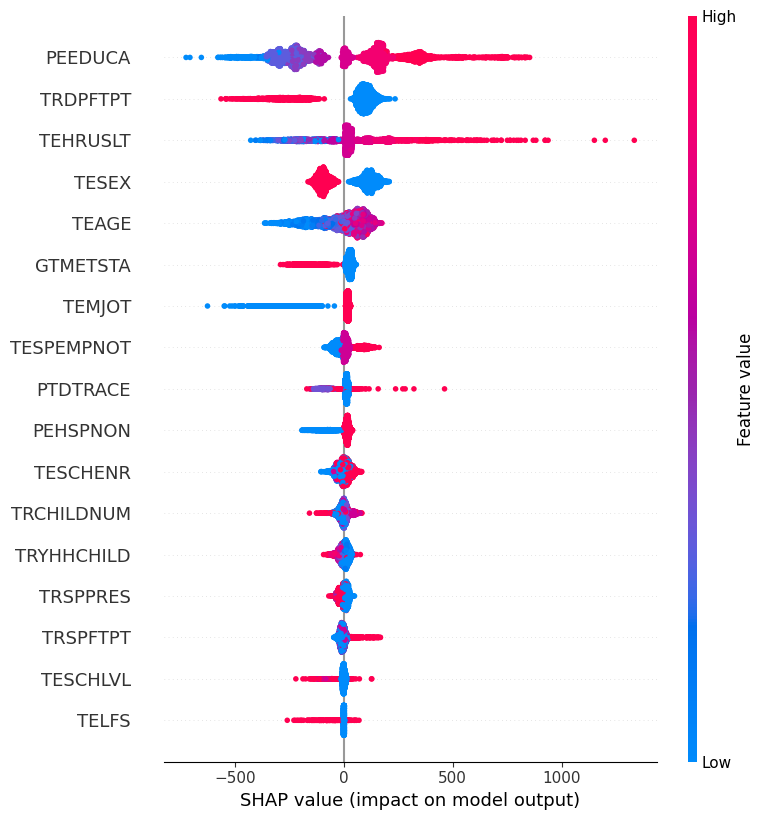

In [17]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-07-30 12:42:32,487] A new study created in memory with name: no-name-30055e42-70c1-4aa6-ba0f-5ac2c14758dc


134/134 [==============================] - 0s 434us/step


[I 2024-07-30 12:42:40,036] Trial 0 finished with value: 979.3855278481864 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00011353429268035861}. Best is trial 0 with value: 979.3855278481864.


134/134 [==============================] - 0s 435us/step


[I 2024-07-30 12:42:48,389] Trial 1 finished with value: 590.1650696494979 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0023364561243377855}. Best is trial 1 with value: 590.1650696494979.


134/134 [==============================] - 0s 453us/step


[I 2024-07-30 12:42:58,618] Trial 2 finished with value: 1032.5338762258598 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.0980195736728383e-05}. Best is trial 1 with value: 590.1650696494979.


134/134 [==============================] - 0s 466us/step


[I 2024-07-30 12:43:06,444] Trial 3 finished with value: 396.93777712906996 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007231287213001752}. Best is trial 3 with value: 396.93777712906996.


134/134 [==============================] - 0s 434us/step


[I 2024-07-30 12:43:14,274] Trial 4 finished with value: 393.94390514556795 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0021532659668586835}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 390us/step


[I 2024-07-30 12:43:22,233] Trial 5 finished with value: 1039.264625593924 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 3.372969372163398e-05}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 833us/step


[I 2024-07-30 12:43:30,625] Trial 6 finished with value: 397.7773158594119 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0035369288031034157}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 431us/step


[I 2024-07-30 12:43:38,262] Trial 7 finished with value: 415.8361644772191 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00013313893760024558}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 447us/step


[I 2024-07-30 12:43:48,208] Trial 8 finished with value: 664.6775339723922 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.7657507800054234e-05}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 431us/step


[I 2024-07-30 12:43:56,033] Trial 9 finished with value: 821.4219740063654 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0006721206236369368}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 403us/step


[I 2024-07-30 12:44:02,690] Trial 10 finished with value: 411.2139938083455 and parameters: {'num_layers': 1, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0007844224841040881}. Best is trial 4 with value: 393.94390514556795.


134/134 [==============================] - 0s 442us/step


[I 2024-07-30 12:44:09,871] Trial 11 finished with value: 390.0041418007088 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007308522678842633}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 599us/step


[I 2024-07-30 12:44:15,963] Trial 12 finished with value: 394.8767671779076 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.006679290569216235}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 449us/step


[I 2024-07-30 12:44:24,275] Trial 13 finished with value: 402.65728405765645 and parameters: {'num_layers': 1, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0015785977570802047}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 454us/step


[I 2024-07-30 12:44:30,176] Trial 14 finished with value: 393.2489719994543 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.008333652192061525}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 481us/step


[I 2024-07-30 12:44:40,121] Trial 15 finished with value: 392.0157057180891 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00991492451116249}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 434us/step


[I 2024-07-30 12:44:48,263] Trial 16 finished with value: 414.3039849798791 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0004902648647829398}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 471us/step


[I 2024-07-30 12:44:54,075] Trial 17 finished with value: 391.8873290526044 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009839828835004947}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 425us/step


[I 2024-07-30 12:45:02,185] Trial 18 finished with value: 447.2411151452269 and parameters: {'num_layers': 1, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00021507295299814618}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 462us/step


[I 2024-07-30 12:45:09,781] Trial 19 finished with value: 390.21615188773615 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003837322429813458}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 428us/step


[I 2024-07-30 12:45:18,600] Trial 20 finished with value: 396.69581149896914 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001300852361834275}. Best is trial 11 with value: 390.0041418007088.


134/134 [==============================] - 0s 460us/step


[I 2024-07-30 12:45:26,395] Trial 21 finished with value: 389.02340086415813 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003915525884073842}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 464us/step


[I 2024-07-30 12:45:35,709] Trial 22 finished with value: 391.7736802469437 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0029565816990961506}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 465us/step


[I 2024-07-30 12:45:42,854] Trial 23 finished with value: 393.76219777191824 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004358157521646871}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 465us/step


[I 2024-07-30 12:45:51,643] Trial 24 finished with value: 393.91986508301375 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004849874850455179}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 403us/step


[I 2024-07-30 12:45:59,587] Trial 25 finished with value: 407.5170517201316 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00106858261049416}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 475us/step


[I 2024-07-30 12:46:11,148] Trial 26 finished with value: 623.3591040106198 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00043238643242232607}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 440us/step


[I 2024-07-30 12:46:19,179] Trial 27 finished with value: 391.27969857060316 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004924962220412029}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 438us/step


[I 2024-07-30 12:46:28,223] Trial 28 finished with value: 392.4820170415606 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0020409116910387625}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 396us/step


[I 2024-07-30 12:46:36,277] Trial 29 finished with value: 1027.4485417597336 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 4.7086710741767445e-05}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 483us/step


[I 2024-07-30 12:46:46,129] Trial 30 finished with value: 390.88541988105874 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0032617501940236274}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 485us/step


[I 2024-07-30 12:46:55,923] Trial 31 finished with value: 394.40863513192164 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003412239238366506}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 468us/step


[I 2024-07-30 12:47:03,224] Trial 32 finished with value: 390.8780828126699 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0055925658190859664}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 442us/step


[I 2024-07-30 12:47:12,699] Trial 33 finished with value: 391.59011985791307 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005468040225073718}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 467us/step


[I 2024-07-30 12:47:24,263] Trial 34 finished with value: 408.2917045758955 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0017828279832926893}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 446us/step


[I 2024-07-30 12:47:32,885] Trial 35 finished with value: 395.14962171699636 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0025632104163000433}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 459us/step


[I 2024-07-30 12:47:41,014] Trial 36 finished with value: 394.7366150113478 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006709191914425068}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 448us/step


[I 2024-07-30 12:47:50,907] Trial 37 finished with value: 480.03566687062784 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0008228196357094314}. Best is trial 21 with value: 389.02340086415813.


134/134 [==============================] - 0s 432us/step


[I 2024-07-30 12:47:57,967] Trial 38 finished with value: 388.77863987525177 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004313344000612215}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 435us/step


[I 2024-07-30 12:48:05,806] Trial 39 finished with value: 395.3513268250212 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002462695384733462}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 403us/step


[I 2024-07-30 12:48:14,487] Trial 40 finished with value: 551.0729869513642 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001344751455448823}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 433us/step


[I 2024-07-30 12:48:21,277] Trial 41 finished with value: 392.4222077786914 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004363066104977919}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 444us/step


[I 2024-07-30 12:48:27,809] Trial 42 finished with value: 392.6316478851555 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007108795927520422}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 443us/step


[I 2024-07-30 12:48:36,434] Trial 43 finished with value: 397.9295082966817 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0058143435359393186}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 467us/step


[I 2024-07-30 12:48:45,989] Trial 44 finished with value: 394.5390397638687 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003690142519575666}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 425us/step


[I 2024-07-30 12:48:54,114] Trial 45 finished with value: 422.2680291022067 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 7.54170007839715e-05}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 444us/step


[I 2024-07-30 12:49:04,059] Trial 46 finished with value: 390.3113336904943 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00211429510619068}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 426us/step


[I 2024-07-30 12:49:13,232] Trial 47 finished with value: 391.61746657635103 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001973351968044846}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 398us/step


[I 2024-07-30 12:49:20,741] Trial 48 finished with value: 395.47222849354216 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0027245346882612286}. Best is trial 38 with value: 388.77863987525177.


134/134 [==============================] - 0s 440us/step


[I 2024-07-30 12:49:28,425] Trial 49 finished with value: 397.5435259653382 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00821062051726447}. Best is trial 38 with value: 388.77863987525177.


FrozenTrial(number=38, state=TrialState.COMPLETE, values=[388.77863987525177], datetime_start=datetime.datetime(2024, 7, 30, 12, 47, 50, 907665), datetime_complete=datetime.datetime(2024, 7, 30, 12, 47, 57, 967639), params={'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004313344000612215}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=38, value=None)
133/133 [==============================] - 0s 403us/step


Test MAE: 394.54739051556385
R2 Score: 0.4863587030749871

______
2022 MAE: 445.3055013753564
2022 R2 Score: 0.42364500469752264


PermutationExplainer explainer: 4274it [01:53, 34.23it/s]                       


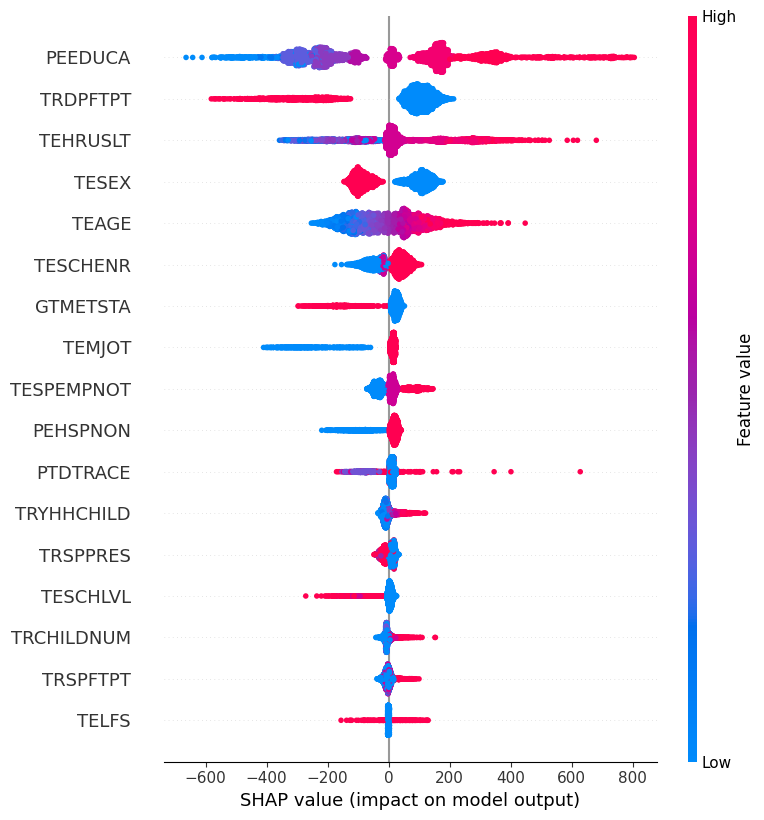

In [19]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### 1D Convolutional Neural Network

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 1s 1ms/step - loss: 900213.8750 - mae: 721.4063 - val_loss: 558516.6250 - val_mae: 575.2896
Epoch 2/100
428/428 [==============================] - 1s 1ms/step - loss: 512842.3125 - mae: 560.1019 - val_loss: 445550.4062 - val_mae: 517.0906
Epoch 3/100
428/428 [==============================] - 1s 1ms/step - loss: 423647.7500 - mae: 502.5980 - val_loss: 383495.9375 - val_mae: 468.0450
Epoch 4/100
428/428 [==============================] - 1s 1ms/step - loss: 391040.8750 - mae: 481.7375 - val_loss: 363279.2500 - val_mae: 452.8631
Epoch 5/100
428/428 [==============================] - 1s 1ms/step - loss: 383413.9062 - mae: 476.5542 - val_loss: 352589.0938 - val_mae: 455.6574
Epoch 6/100
428/428 [==============================] - 1s 1ms/step - loss: 375199.2188 - mae: 473.1397 - val_loss: 347369.8750 - val_mae: 443.1456
Epoch 7/100
428/428 [==============================] - 1s 1ms/step - loss: 373056.0000 - mae: 470.2029 - val_loss: 342

#### Hyperparameter Tuning: Optuna

In [22]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-07-30 12:56:35,960] A new study created in memory with name: no-name-49769c68-bd9a-4097-8920-e8847edd8c17


134/134 [==============================] - 0s 698us/step


[I 2024-07-30 12:56:46,387] Trial 0 finished with value: 592.8301698745666 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.35462392008364774, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.007424638986514606}. Best is trial 0 with value: 592.8301698745666.


134/134 [==============================] - 0s 638us/step


[I 2024-07-30 12:57:14,343] Trial 1 finished with value: 980.9623042533404 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.4878282044983875, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 3.153095511308098e-05}. Best is trial 0 with value: 592.8301698745666.


134/134 [==============================] - 0s 711us/step


[I 2024-07-30 12:57:44,695] Trial 2 finished with value: 1000.2463816860636 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.20090886849324335, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 1.0670067191218602e-05}. Best is trial 0 with value: 592.8301698745666.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 12:58:22,347] Trial 3 finished with value: 385.174196890912 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1828906632331228, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0036174032274630423}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 705us/step


[I 2024-07-30 12:58:50,932] Trial 4 finished with value: 965.6815185775417 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.03294459658306881, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 2.731946219031424e-05}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 559us/step


[I 2024-07-30 12:59:16,268] Trial 5 finished with value: 419.2245387886917 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.13843816268729014, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 6.60343399091208e-05}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 809us/step


[I 2024-07-30 12:59:58,698] Trial 6 finished with value: 777.8697484008875 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.4686418865707057, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00042234149976973304}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 514us/step


[I 2024-07-30 13:00:19,699] Trial 7 finished with value: 1003.837868333634 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.4972215690016509, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.00010039697167595045}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 736us/step


[I 2024-07-30 13:00:42,709] Trial 8 finished with value: 400.3020186600349 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.24468577390551643, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0045660272323172725}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 544us/step


[I 2024-07-30 13:01:04,989] Trial 9 finished with value: 534.0036990330019 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06779414222671132, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 3.092664322282419e-05}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 958us/step


[I 2024-07-30 13:01:26,558] Trial 10 finished with value: 395.6925191701304 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3139743352866382, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0017675978514501143}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 967us/step


[I 2024-07-30 13:01:48,174] Trial 11 finished with value: 389.78760258320676 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3324995205154835, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0014634440306635283}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 922us/step


[I 2024-07-30 13:02:29,739] Trial 12 finished with value: 392.53431173795514 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.36960612676525634, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0010237828916911074}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 999us/step


[I 2024-07-30 13:03:14,511] Trial 13 finished with value: 392.7381606027937 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.15888050207625598, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0022567379107393338}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 789us/step


[I 2024-07-30 13:03:55,827] Trial 14 finished with value: 394.6960800391451 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.2874810710629133, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0005611523871367818}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:04:23,291] Trial 15 finished with value: 387.1570066431047 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.39463823789038477, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0032517011246016576}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 682us/step


[I 2024-07-30 13:04:41,977] Trial 16 finished with value: 402.5906199599217 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4117886918212688, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0088570037478318}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 626us/step


[I 2024-07-30 13:04:56,913] Trial 17 finished with value: 394.0173461730871 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.11968001543978746, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0032519461723498054}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 629us/step


[I 2024-07-30 13:05:26,187] Trial 18 finished with value: 431.81360795199384 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.24199839883443566, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.00022628753801847014}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 701us/step


[I 2024-07-30 13:05:58,436] Trial 19 finished with value: 396.5140404082873 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.43613652899629857, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0007491593951684542}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:06:36,307] Trial 20 finished with value: 409.5643590272653 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.20767988201965498, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.00022884198071187914}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 910us/step


[I 2024-07-30 13:07:18,933] Trial 21 finished with value: 391.87846870666084 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.31796098699211023, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.001455291052720679}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 537us/step


[I 2024-07-30 13:07:37,694] Trial 22 finished with value: 402.01566770113914 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3964090038202758, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.003804936407851226}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 820us/step


[I 2024-07-30 13:08:05,739] Trial 23 finished with value: 393.81059728016714 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.28499108508091536, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0011725636200335735}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:08:48,823] Trial 24 finished with value: 388.01355208679246 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.34436009332781803, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.005514367677916174}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 780us/step


[I 2024-07-30 13:09:07,938] Trial 25 finished with value: 387.24671464973164 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.43179773659247356, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.005223734350136143}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 765us/step


[I 2024-07-30 13:09:32,217] Trial 26 finished with value: 390.63033888338543 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.44906955484938904, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.003063742383882767}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 647us/step


[I 2024-07-30 13:09:47,644] Trial 27 finished with value: 395.83389393533946 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3971002761369577, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009956123697609485}. Best is trial 3 with value: 385.174196890912.


134/134 [==============================] - 0s 856us/step


[I 2024-07-30 13:10:27,302] Trial 28 finished with value: 383.61306109999094 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.18390068480449528, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002458272840848939}. Best is trial 28 with value: 383.61306109999094.


134/134 [==============================] - 0s 639us/step


[I 2024-07-30 13:10:52,560] Trial 29 finished with value: 385.6267446398763 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0877873198180373, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.002660139961467146}. Best is trial 28 with value: 383.61306109999094.


134/134 [==============================] - 0s 633us/step


[I 2024-07-30 13:11:17,890] Trial 30 finished with value: 389.7636338292646 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0917736968687862, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.002202113636494563}. Best is trial 28 with value: 383.61306109999094.


134/134 [==============================] - 0s 665us/step


[I 2024-07-30 13:11:45,471] Trial 31 finished with value: 380.8637077559371 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18815179949530875, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.002307859972843145}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 657us/step


[I 2024-07-30 13:12:02,965] Trial 32 finished with value: 385.7095935581028 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1899640481492691, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.005979606276658856}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 633us/step


[I 2024-07-30 13:12:28,904] Trial 33 finished with value: 387.1879914562066 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.09659037246894418, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0009792670403655954}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 669us/step


[I 2024-07-30 13:12:55,071] Trial 34 finished with value: 397.2197085349532 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.02160870680751316, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.002035954886197922}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 692us/step


[I 2024-07-30 13:13:24,016] Trial 35 finished with value: 395.1543213167733 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.16365395681391967, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.000716237864449173}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 687us/step


[I 2024-07-30 13:13:39,705] Trial 36 finished with value: 592.8917821294319 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.21227196386459823, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.007077163255008787}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 655us/step


[I 2024-07-30 13:14:06,722] Trial 37 finished with value: 393.025384978141 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.050903007498504405, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0003727195657347052}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 674us/step


[I 2024-07-30 13:14:33,431] Trial 38 finished with value: 1005.4236899302575 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.1430960795974167, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 1.6511021348145523e-05}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 661us/step


[I 2024-07-30 13:15:00,361] Trial 39 finished with value: 409.5294773082033 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1896799652069227, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00010354625985031474}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 706us/step


[I 2024-07-30 13:15:30,556] Trial 40 finished with value: 396.4245423171036 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.11398288525738556, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0025630040708003146}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 661us/step


[I 2024-07-30 13:15:53,526] Trial 41 finished with value: 388.67863831387734 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18048776097946057, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0059981282745730025}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 632us/step


[I 2024-07-30 13:16:12,875] Trial 42 finished with value: 387.9870808180316 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.23766603869922392, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004095651774468821}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 677us/step


[I 2024-07-30 13:16:40,265] Trial 43 finished with value: 396.47717525215245 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.003924739789696888, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0016367685027398958}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:17:02,327] Trial 44 finished with value: 392.6327519475329 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2695553925011023, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.007345665102602489}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 660us/step


[I 2024-07-30 13:17:30,514] Trial 45 finished with value: 388.4912758429715 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.21821717381885888, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.004290105821796399}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 678us/step


[I 2024-07-30 13:17:58,461] Trial 46 finished with value: 392.48949056691873 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1681189531790988, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.002805357684512544}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 645us/step


[I 2024-07-30 13:18:24,342] Trial 47 finished with value: 393.2722105249521 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.1388857178537904, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00125901222756863}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 981us/step


[I 2024-07-30 13:19:15,096] Trial 48 finished with value: 402.1098264133302 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.07147332877141377, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.001843285960593039}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 586us/step


[I 2024-07-30 13:19:30,818] Trial 49 finished with value: 388.9620881113971 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2297488393527849, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0060062983842966555}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 926us/step


[I 2024-07-30 13:20:20,391] Trial 50 finished with value: 396.10529189551045 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.26612811388334834, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0005769065764513207}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 618us/step


[I 2024-07-30 13:20:36,514] Trial 51 finished with value: 398.18473256518905 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.12762771691411007, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0032294157119446528}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 788us/step


[I 2024-07-30 13:21:02,077] Trial 52 finished with value: 387.7917096483805 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.18942003712843586, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.003713974041048601}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 667us/step


[I 2024-07-30 13:21:19,515] Trial 53 finished with value: 390.7145659696551 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.15493137177149616, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0026413520035490907}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 519us/step


[I 2024-07-30 13:21:29,992] Trial 54 finished with value: 391.92062851419945 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20468961742467334, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.007353437739766309}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 751us/step


[I 2024-07-30 13:21:54,187] Trial 55 finished with value: 398.4975565897171 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.48055500018313185, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.004319194588046715}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 951us/step


[I 2024-07-30 13:22:19,048] Trial 56 finished with value: 388.38042216955574 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17805696718020367, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002086774589370475}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 866us/step


[I 2024-07-30 13:22:57,065] Trial 57 finished with value: 387.7537935008909 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.257735350192721, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0009996409851380477}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 857us/step


[I 2024-07-30 13:23:22,478] Trial 58 finished with value: 393.595939131937 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.11102650892459162, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.005070088038555516}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 573us/step


[I 2024-07-30 13:23:44,700] Trial 59 finished with value: 396.6847876418293 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.30091979847147554, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0015218035098385997}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 552us/step


[I 2024-07-30 13:23:58,190] Trial 60 finished with value: 389.8047822044082 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.22586202455711912, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.00873952958770371}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 633us/step


[I 2024-07-30 13:24:24,228] Trial 61 finished with value: 383.31128890576986 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.08226363733990955, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0025186277928340274}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 647us/step


[I 2024-07-30 13:24:51,249] Trial 62 finished with value: 386.5854163621813 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.05983528228791535, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0031874928875508155}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 658us/step


[I 2024-07-30 13:25:16,620] Trial 63 finished with value: 385.3079124682083 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06793603106950874, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0025597645433239496}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 646us/step


[I 2024-07-30 13:25:43,643] Trial 64 finished with value: 381.6653995759064 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0948628160986214, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0023832473448117653}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:26:09,150] Trial 65 finished with value: 387.7820337800379 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.08405471630835379, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.002388053949026677}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 645us/step


[I 2024-07-30 13:26:36,058] Trial 66 finished with value: 388.56697055958597 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.041233959209411704, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0007722548279048277}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 649us/step


[I 2024-07-30 13:27:03,091] Trial 67 finished with value: 401.2177493684297 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.07653901534065867, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.001290051251236337}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 628us/step


[I 2024-07-30 13:27:28,369] Trial 68 finished with value: 393.2556454560262 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.10115468889969113, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0018884822363456986}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 650us/step


[I 2024-07-30 13:27:55,418] Trial 69 finished with value: 388.31041715508127 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.03799213820822363, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0016153426583666267}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 669us/step


[I 2024-07-30 13:28:23,461] Trial 70 finished with value: 419.802085105727 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.018335689822218004, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 6.120063344554901e-05}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 675us/step


[I 2024-07-30 13:28:47,434] Trial 71 finished with value: 385.8130850019752 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.12745039854006474, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0036550514788718878}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 642us/step


[I 2024-07-30 13:29:13,696] Trial 72 finished with value: 395.11031095755175 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06100778676279461, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.002528066265491742}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 621us/step


[I 2024-07-30 13:29:33,014] Trial 73 finished with value: 388.9845173598954 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1543099454395667, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004975963025252233}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 670us/step


[I 2024-07-30 13:29:56,771] Trial 74 finished with value: 387.30441542676095 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.10591550031497678, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.006494844257717165}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 606us/step


[I 2024-07-30 13:30:21,465] Trial 75 finished with value: 385.0544780865648 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.14712326185153837, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.002172624974802708}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:30:44,676] Trial 76 finished with value: 395.9668578445217 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.08824161147974352, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0021852267151131243}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 593us/step


[I 2024-07-30 13:31:09,380] Trial 77 finished with value: 390.1140208246154 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.12760627665939914, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0011733412671347896}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 645us/step


[I 2024-07-30 13:31:35,396] Trial 78 finished with value: 392.4500418441848 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.17171796134694908, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.003469195601577002}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 622us/step


[I 2024-07-30 13:32:00,818] Trial 79 finished with value: 397.58389304316637 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.14841940924964286, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.00026194715519193304}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 714us/step


[I 2024-07-30 13:32:33,694] Trial 80 finished with value: 392.5551599965987 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.07765500704457344, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0008517637292616096}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 643us/step


[I 2024-07-30 13:32:53,503] Trial 81 finished with value: 392.66385998697996 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2003903369421136, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0029878727506231816}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 670us/step


[I 2024-07-30 13:33:17,423] Trial 82 finished with value: 388.55220288970116 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.11955033321547608, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.004295684470892643}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 685us/step


[I 2024-07-30 13:33:46,571] Trial 83 finished with value: 384.99564906296393 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18586056517261948, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.001770319287256907}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 677us/step


[I 2024-07-30 13:34:15,676] Trial 84 finished with value: 385.49049937838555 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.04933598034125969, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0014102003044466774}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 687us/step


[I 2024-07-30 13:34:44,786] Trial 85 finished with value: 384.4194706657154 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.05797632766801321, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0013633935706385968}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 604us/step


[I 2024-07-30 13:35:06,331] Trial 86 finished with value: 391.0643741234678 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.13856668454767707, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0018442326143035806}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:36:05,130] Trial 87 finished with value: 389.05533996189223 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.16508758907329021, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00222321528083915}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 666us/step


[I 2024-07-30 13:36:34,681] Trial 88 finished with value: 392.4123687233669 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.028816228157822216, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0017878899333131013}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 695us/step


[I 2024-07-30 13:37:10,152] Trial 89 finished with value: 391.20087391295147 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1992776325268274, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0014438711199754083}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 701us/step


[I 2024-07-30 13:37:43,114] Trial 90 finished with value: 393.0656159259306 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06265927560034079, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00061389450589154}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 705us/step


[I 2024-07-30 13:38:12,056] Trial 91 finished with value: 383.8040288402291 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.009822634292324037, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0014492101782606073}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 700us/step


[I 2024-07-30 13:38:41,052] Trial 92 finished with value: 385.6429480835718 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.09868600364631941, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0009837186414018493}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 696us/step


[I 2024-07-30 13:39:10,221] Trial 93 finished with value: 392.6286288957799 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.009211580551754542, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00048063970394974484}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 675us/step


[I 2024-07-30 13:39:34,466] Trial 94 finished with value: 391.43853414137806 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.04618728168982061, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0027954502320047124}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 680us/step


[I 2024-07-30 13:39:52,694] Trial 95 finished with value: 395.5584306675764 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.03077236492507779, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0011392895533822516}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 13:40:36,721] Trial 96 finished with value: 392.012285793991 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.17895226557620994, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0023902461301024734}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 696us/step


[I 2024-07-30 13:41:06,590] Trial 97 finished with value: 388.2331547709581 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1933972935633546, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.002002185270266155}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 693us/step


[I 2024-07-30 13:41:35,590] Trial 98 finished with value: 394.1623948556948 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2150989481562707, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.001631827207229796}. Best is trial 31 with value: 380.8637077559371.


134/134 [==============================] - 0s 632us/step


[I 2024-07-30 13:41:57,073] Trial 99 finished with value: 390.3929347050813 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.013210087173409515, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0030651340058284113}. Best is trial 31 with value: 380.8637077559371.


FrozenTrial(number=31, state=TrialState.COMPLETE, values=[380.8637077559371], datetime_start=datetime.datetime(2024, 7, 30, 13, 11, 17, 891004), datetime_complete=datetime.datetime(2024, 7, 30, 13, 11, 45, 471577), params={'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18815179949530875, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.002307859972843145}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribut

In [23]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 0s 661us/step


Test MAE: 386.32381201106887
R2 Score: 0.5006438076088677

______
2022 MAE: 444.8546256521851
2022 R2 Score: 0.41580693715711003


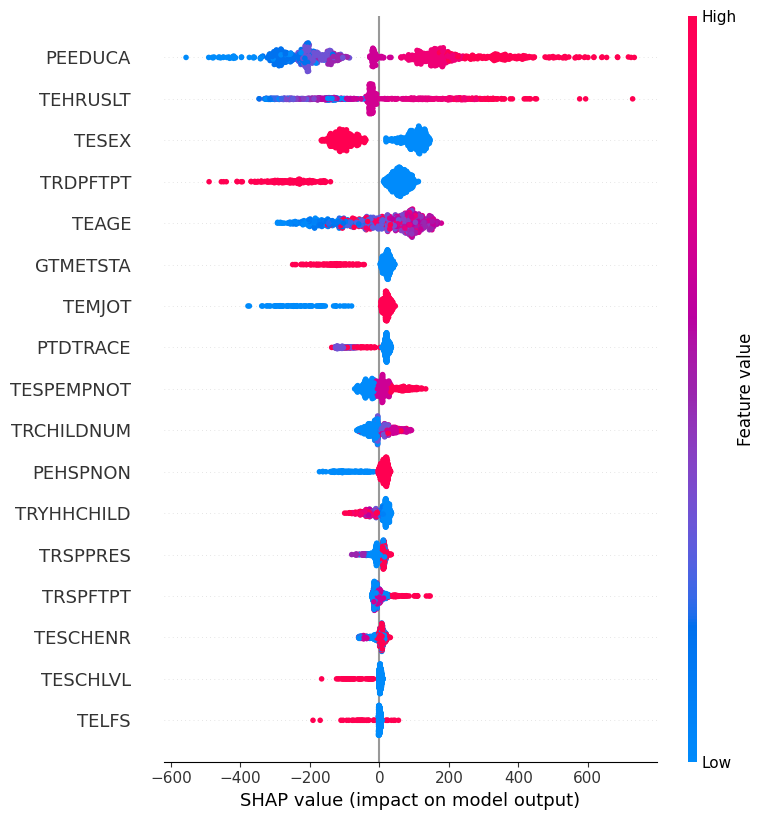

In [38]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)